In [1]:
from Bio import SeqIO
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from Bio.Graphics.ColorSpiral import ColorSpiral

from IPython.display import Image, HTML
import pandas as pd
from io import StringIO
import networkx as nx
from networkx import to_numpy_matrix
import matplotlib.pyplot as plt
import pickle

In [48]:
pd.set_option('display.max_colwidth',500)

In [354]:
# 提取 pathway，保存 pathway 节点
pathway_nodes = kegg_list('pathway', 'hsa').read()
pathway_nodes_df = pd.read_csv(StringIO(pathway_nodes), sep='\t', header=None)
pathway_nodes_df[0].to_csv('data/pathway_nodes.csv', header=0, index=0)
pathway_nodes_df.to_csv('data/pathway_nodes_annotate.csv', header=0, index=0)

In [355]:
#pathway2xml = KGML_parser.read(kegg_get('hsa00010', "kgml"))
#pathway2xml_1 = KGML_parser.read(kegg_get('ko00010', "kgml"))
pathwaylist = list(pathway_nodes_df[0])
enzymeDict = {}
path2path = list()
allnum = len(pathwaylist)
procress = 0
for pathwayname in pathwaylist[1:15]:
    # print('request '+ pathwayname + ' xml file...')
    if procress % (allnum//10) == 0:
        print(f"Epoch {procress}/{allnum}")
    procress += 1
    pathway2xml = KGML_parser.read(kegg_get(pathwayname, "kgml"))
    path2path.extend([[pathwayname, maps.name] for maps in pathway2xml.maps if maps.name in pathwaylist])
    relation2entry = pd.DataFrame(columns=('id1', 'id2', 'id1name', 'id2name'))
    genelist = pathway2xml.genes
    for i, gene in enumerate(pathway2xml.relations):
        if gene.entry1 in genelist and gene.entry2 in genelist:
            relation2entry.loc[i,:] = [pathwayname+'_'+str(gene.entry1.id), 
                                       pathwayname+'_'+str(gene.entry2.id), 
                                       gene.entry1.name, gene.entry2.name]
    net = nx.from_pandas_edgelist(relation2entry, 'id1', 'id2')
    order = sorted(list(net.nodes()), key=lambda x: int(x.split('_')[1]))
    A = nx.to_numpy_matrix(net, nodelist=order)
    id2gene = [(pathwayname+'_'+str(gene.id), gene.name) for gene in genelist]
    enzymeDict[pathwayname] = {'name': order, 'matrix': A, 'gene2id': id2gene}

Epoch 0/333


In [356]:
with open('data/enzymeDict.pickle.txt','wb') as file:
    pickle.dump(enzymeDict,file)

In [357]:
path2path = pd.DataFrame(path2path, columns=('path1', 'path2'))
path2path.to_csv('data/path2path.csv', header=0, index=0)

In [358]:
path2path

,path1,path2
0,path:hsa00020,path:hsa00630
1,path:hsa00020,path:hsa00010
2,path:hsa00020,path:hsa00061
3,path:hsa00020,path:hsa00062
4,path:hsa00020,path:hsa00071
5,path:hsa00020,path:hsa00053
6,path:hsa00020,path:hsa00250
7,path:hsa00020,path:hsa00020
8,path:hsa00020,path:hsa00350
9,path:hsa00020,path:hsa00280


In [359]:
rows=[i for i in path2path.index if path2path.iat[i,0]==path2path.iat[i,1]]
path2path2=path2path.drop(rows,axis=0) #利用drop方法将含 path1=path2 的行删除
path2path2 = path2path2.drop_duplicates(['path1', 'path2'], keep='first') # 删除重复行
a=path2path2.apply(lambda x: str(sorted(x.tolist())), axis=1)
pos = pd.DataFrame(a).duplicated()
path2path_drop = path2path2.loc[-pos,:].reset_index()
path2path_drop[['path1', 'path2']].to_csv('data/path2path.csv', header=0, index=0)

In [293]:
enzymeDict_load['path:hsa00010']

{'name': ['path:hsa00010_14',
  'path:hsa00010_38',
  'path:hsa00010_40',
  'path:hsa00010_45',
  'path:hsa00010_46',
  'path:hsa00010_48',
  'path:hsa00010_49',
  'path:hsa00010_50',
  'path:hsa00010_51',
  'path:hsa00010_53',
  'path:hsa00010_55',
  'path:hsa00010_56',
  'path:hsa00010_57',
  'path:hsa00010_58',
  'path:hsa00010_59',
  'path:hsa00010_60',
  'path:hsa00010_62',
  'path:hsa00010_63',
  'path:hsa00010_64',
  'path:hsa00010_65',
  'path:hsa00010_66',
  'path:hsa00010_67',
  'path:hsa00010_69',
  'path:hsa00010_70',
  'path:hsa00010_71',
  'path:hsa00010_72',
  'path:hsa00010_75',
  'path:hsa00010_76',
  'path:hsa00010_112',
  'path:hsa00010_128',
  'path:hsa00010_129',
  'path:hsa00010_131',
  'path:hsa00010_133',
  'path:hsa00010_134',
  'path:hsa00010_140'],
 'matrix': matrix([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0.,

In [ ]:
with open('data/enzymeDict.pickle.txt','rb') as file:
    enzymeDict_load = pickle.load(file)
enzymeDict_load['path:hsa00010']['gene2id']

In [13]:
allgene = []
for path in list(enzymeDict_load.keys()):
    for gene in enzymeDict_load[path]['gene2id']:
        allgene.extend(gene[1].split(' '))
allgene_drop = list(set(allgene))

In [95]:
# 利用 bioDBnet 的api 进行id转换
# import requests, json
# from pandas.io.json import json_normalize
# batch = 300
# req = []
# for index in range(0, len(allgene_drop), batch):
#     print(index)
#     url = ('https://biodbnet-abcc.ncifcrf.gov/webServices/rest.php/biodbnetRestApi.json?method=db2db&input=KEGG Gene ID&inputValues=' + 
#            ','.join(allgene_drop[index:index+batch]) + 
#            '&outputs=HGNC ID&taxonId=9606&format=row')
#     req.extend(requests.get(url).json())
# HGNCID2hsaID = json_normalize(req)
# HGNCID2hsaID.to_csv('data/HGNCID2hsaID.csv', index=0, header=0)

0
300
600
900
1200
1500
1800
2100
2400
2700
3000
3300
3600
3900
4200
4500
4800
5100
5400
5700
6000
6300
6600
6900
7200
7500
7800


In [166]:
hgncFile = pd.read_csv('E:/wx/2019上课题/数据/hgnc_complete_set.txt', sep='\t', # protein-coding_gene.txt
                       usecols=['hgnc_id', 'symbol', 'name', 'alias_symbol', 'entrez_id', 'ensembl_gene_id', 'uniprot_ids', 'enzyme_id'],
                       engine='python', 
                       dtype={'entrez_id': str})

In [167]:
hgncFile.head()

,hgnc_id,symbol,name,alias_symbol,entrez_id,ensembl_gene_id,uniprot_ids,enzyme_id
0,HGNC:5,A1BG,alpha-1-B glycoprotein,NaN,1,ENSG00000121410,P04217,NaN
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,FLJ23569,503538,ENSG00000268895,NaN,NaN
2,HGNC:24086,A1CF,APOBEC1 complementation factor,ACF|ASP|ACF64|ACF65|APOBEC1CF,29974,ENSG00000148584,Q9NQ94,NaN
3,HGNC:7,A2M,alpha-2-macroglobulin,FWP007|S863-7|CPAMD5,2,ENSG00000175899,P01023,NaN
4,HGNC:27057,A2M-AS1,A2M antisense RNA 1,NaN,144571,ENSG00000245105,NaN,NaN


In [168]:
gene2symbol = hgncFile.loc[hgncFile['entrez_id'].isin([i[4:] for i in allgene_drop])]

In [173]:
PPI_gene = pd.read_csv('E:/wx/2019上课题/数据/9606.protein.info.v11.0.txt', sep='\t',
                       usecols=['protein_external_id', 'preferred_name'],
                       engine='python')

In [349]:
hsa2symbol = hgncFile.loc[hgncFile['symbol'].isin(finalgene['preferred_name'])][['symbol', 'entrez_id']]
hsa2symbol['entrez_id'] = hsa2symbol.apply(lambda x: 'hsa:'+str(x[1]), axis=1)
hsa2symbol.reset_index(drop=True)

,symbol,entrez_id
0,A2M,hsa:2
1,A3GALT2,hsa:127550
2,A4GALT,hsa:53947
3,AAAS,hsa:8086
4,AACS,hsa:65985
5,AADAT,hsa:51166
6,AANAT,hsa:15
7,AARS,hsa:16
8,AARS2,hsa:57505
9,AASDHPPT,hsa:60496


In [185]:
finalgene = PPI_gene.loc[PPI_gene['preferred_name'].isin(gene2symbol['symbol'])]

In [191]:
# 1.gene_nodes.csv --- 7047个gene symbol
finalgene['preferred_name'].to_csv('data/gene_nodes.csv', header=0, index=0)

In [268]:
protein_ensp_id = list(finalgene['protein_external_id'])
proetin_protein = []
outputfile = open('data/protein_protein_edges.csv', 'w')
with open('E:/wx/2019上课题/数据/9606.protein.links.v11.0.txt', 'r') as file:
    i = 0
    for r in file.readlines():
        if i % (11759455//10)==0:
            print(i)
        i += 1
        p1, p2, s = r.strip().split(' ')
        if p1 in protein_ensp_id and p2 in protein_ensp_id:  
            outputfile.write(finalgene.loc[finalgene.protein_external_id==p1, 'preferred_name'].values[0] + ',' +
                              finalgene.loc[finalgene.protein_external_id==p2, 'preferred_name'].values[0] + ',' + s + '\n')
outputfile.close()

0
1175945
2351890
3527835
4703780
5879725
7055670
8231615
9407560
10583505
11759450


In [269]:
finalgene.loc[finalgene.protein_external_id=='9606.ENSP00000000233', 'preferred_name'][0]

'ARF5'

In [272]:
PPI = pd.read_csv('data/protein_protein_edges.csv', sep=',',
                  names =['p1','p2', 'score'],
                  header=None,
                  engine='python')

In [278]:
ppi_drop = PPI.drop_duplicates()

In [282]:
sortppi = ppi_drop[['p1', 'p2']].apply(lambda x: str(sorted(x.tolist())), axis=1)
pos = pd.DataFrame(sortppi).duplicated()
ppi_drop = ppi_drop.loc[-pos,:].reset_index()

In [286]:
ppi_drop = ppi_drop[['p1','p2', 'score']]

In [288]:
ppi_drop.to_csv('data/protein_protein_edges_drop_duplicated.csv', header=0, index=0)

In [351]:
# 2.protein_protein_edges.csv --- 蛋白蛋白互作关系，存储为symbol--symbol
for i in range(10):
    if i % 3 ==0:
        print(i)

0
3
6
9


d:\python36\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


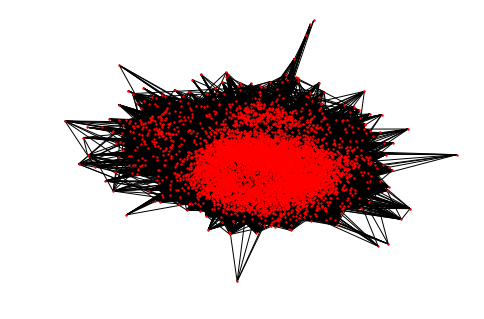

In [289]:
net = nx.from_pandas_edgelist(ppi_drop, 'p1', 'p2')
fig = plt.figure()
nx.draw(net, with_labels=False,node_size=2)
plt.show()

7407

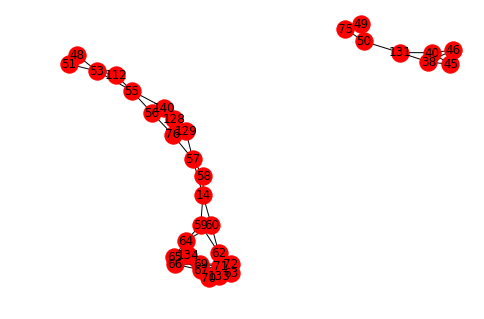

In [164]:
net = nx.from_pandas_edgelist(relation2entry, 'id1', 'id2')
fig = plt.figure()
nx.draw(net, with_labels=True)
plt.show()

In [127]:
a=pathway2xml.relations[0]
a.entry1.id

51

In [83]:
e38_1 = pathway2xml_1.entries[38]
e38_1.name

'hsa:2271'

In [84]:
e38 = pathway2xml.entries[38]
e38.name

'hsa:217 hsa:219 hsa:223 hsa:224 hsa:501'

In [87]:
rel = pathway2xml.relations[0]
rel.

In [14]:
# 提取 Enzyme，保存 Enzyme 节点
enzyme_nodes = kegg_link('enzyme', 'hsa').read()
enzyme_nodes_df = pd.read_csv(StringIO(enzyme_nodes), sep='\t', header=None)
# enzyme_nodes_df

In [ ]:
# 提取 pathway 互作关系

In [ ]:
# 提取 Enzyme 互作关系

In [ ]:
# 提取 Enzyme 对应的基因

In [17]:
import re

In [51]:
gene2ec = pd.DataFrame(columns=('hsaid', 'gene', 'ec'))
num = 0
with open('data/hsa00001.keg', 'r') as keg:
    for row in keg.readlines():
        if row[0] == 'D':
            ls = re.split(r'[;\s]\s*',row.strip())
            gene2ec.loc[num] = [ls[1], ls[2],ls[-1]]
            num += 1

In [62]:
num

44869

In [54]:
drop = gene2ec.drop_duplicates(['hsaid', 'gene', 'ec'], keep='first')

In [65]:
enzyme_nodes_df.drop_duplicates([0,1], keep='first').shape

(3634, 2)